### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import warnings
import progressbar
from tqdm import tqdm

import torch.autograd as autograd
from torch.autograd import Variable

warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:46<00:00, 564kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:01<00:00, 23.3kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:21<00:00, 202kB/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 3.64MB/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

### Изначальный

In [51]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

	[1/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 461.85it/s]


	 errD_x: 0.16 errD_z: 0.14 errG: 2.76
	[2/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 456.85it/s]


	 errD_x: 0.19 errD_z: 0.14 errG: 2.72
	[3/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 485.93it/s]


	 errD_x: 0.26 errD_z: 0.16 errG: 2.59
	[4/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 490.02it/s]


	 errD_x: 0.30 errD_z: 0.19 errG: 2.58
	[5/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 494.29it/s]


	 errD_x: 0.38 errD_z: 0.23 errG: 2.34
	[6/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 492.49it/s]


	 errD_x: 0.32 errD_z: 0.20 errG: 2.43
	[7/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 486.66it/s]


	 errD_x: 0.42 errD_z: 0.25 errG: 2.31
	[8/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 492.28it/s]


	 errD_x: 0.40 errD_z: 0.25 errG: 2.28
	[9/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 491.16it/s]


	 errD_x: 0.36 errD_z: 0.23 errG: 2.39
	[10/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:07<00:00, 498.87it/s]


	 errD_x: 0.39 errD_z: 0.25 errG: 2.23


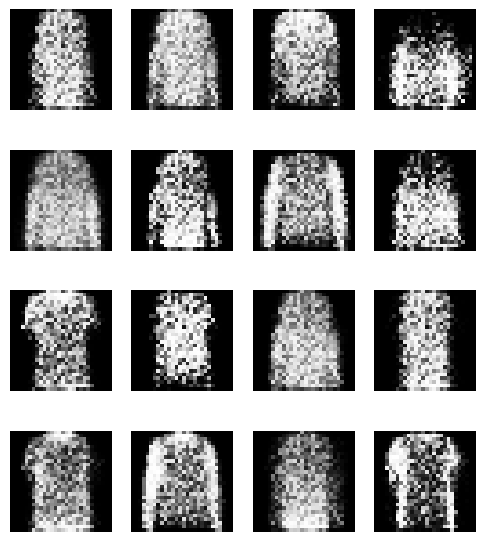

In [52]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    print(f'\t[{(epoch+1)}/{config.num_epochs}] Traning...')

    errD_xs = []
    errD_zs = []
    errGs = []

    for images, cat in tqdm(dataloader):
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(16, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(16, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()
        # Generator stage: maximize log(D(G(x))
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(16, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        errD_xs.append(errD_x.item())
        errD_zs.append(errD_z.item())
        errGs.append(errG.item())
    
    print(
        f'\t',
        f'errD_x: {np.mean(errD_xs):.2f}',
        f'errD_z: {np.mean(errD_zs):.2f}',
        f'errG: {np.mean(errGs):.2f}'
    )

noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Wasserstein GAN

In [53]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())  # Изменить на Tanh для нормализации выходного диапазона

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )  

    def forward(self, x):
        return self.model(x)

    def weight_clipping(self, min_weight=-0.01, max_weight=0.01):
        for param in self.parameters():
            param.data.clamp_(min_weight, max_weight)

	[1/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:09<00:00, 400.58it/s]


	 errD_x: 0.67 errD_z: 0.69 errG: 0.70
	[2/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 440.47it/s]


	 errD_x: 0.68 errD_z: 0.69 errG: 0.70
	[3/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 459.61it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.70
	[4/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 433.30it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.70
	[5/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 421.99it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.70
	[6/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 455.54it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.69
	[7/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 435.68it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.69
	[8/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 428.84it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.69
	[9/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 468.29it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.69
	[10/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:08<00:00, 421.81it/s]


	 errD_x: 0.69 errD_z: 0.69 errG: 0.69


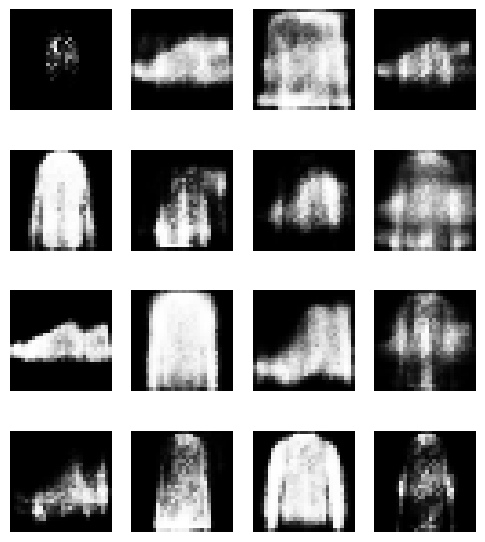

In [55]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    print(f'\t[{(epoch+1)}/{config.num_epochs}] Traning...')

    errD_xs = []
    errD_zs = []
    errGs = []

    for images, cat in tqdm(dataloader):
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(16, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(16, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        optim_D.step()
        discriminator.weight_clipping()  # Добавляем

        # Generator stage: maximize log(D(G(x))
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(16, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        errD_xs.append(errD_x.item())
        errD_zs.append(errD_z.item())
        errGs.append(errG.item())
    
    print(
        f'\t',
        f'errD_x: {np.mean(errD_xs):.2f}',
        f'errD_z: {np.mean(errD_zs):.2f}',
        f'errG: {np.mean(errGs):.2f}'
    )

noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Замена на gradient penalty

In [94]:
LAMBDA = 10

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())  

    def forward(self, x):
        return self.model(x)

def gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(16, 1)
    alpha = alpha.expand(real_data.size())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates,
                              inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

	[1/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 349.85it/s]


	 errD_x: 0.49 errD_z: 0.68 errG: 0.74
	[2/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 363.17it/s]


	 errD_x: 0.35 errD_z: 0.67 errG: 0.73
	[3/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 362.88it/s]


	 errD_x: 0.35 errD_z: 0.64 errG: 0.78
	[4/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:11<00:00, 339.09it/s]


	 errD_x: 0.38 errD_z: 0.73 errG: 0.71
	[5/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 363.58it/s]


	 errD_x: 0.37 errD_z: 0.47 errG: 1.05
	[6/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 360.89it/s]


	 errD_x: 0.34 errD_z: 0.43 errG: 1.14
	[7/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 354.50it/s]


	 errD_x: 0.41 errD_z: 0.47 errG: 1.06
	[8/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 360.67it/s]


	 errD_x: 0.40 errD_z: 0.46 errG: 1.08
	[9/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 360.53it/s]


	 errD_x: 0.40 errD_z: 0.47 errG: 1.06
	[10/10] Traning...


100%|██████████████████████████████████████| 3750/3750 [00:10<00:00, 363.44it/s]


	 errD_x: 0.41 errD_z: 0.47 errG: 1.06


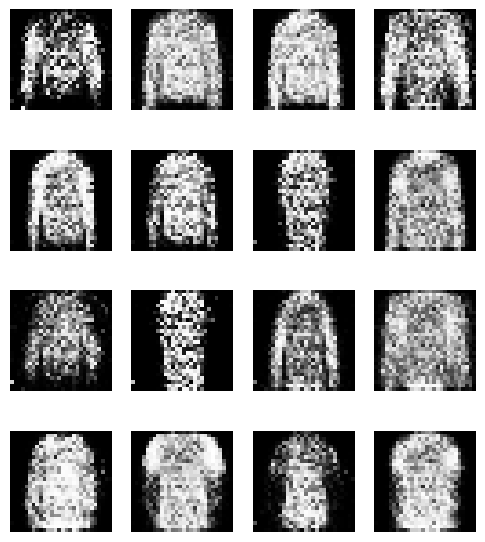

In [95]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    print(f'\t[{(epoch+1)}/{config.num_epochs}] Traning...')

    errD_xs = []
    errD_zs = []
    errGs = []

    for images, cat in tqdm(dataloader):
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(16, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(16, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        loss = gradient_penalty(discriminator, input_data, fake.detach())
        loss.backward()

        optim_D.step()
        
        # Generator stage: maximize log(D(G(x))
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(16, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        errD_xs.append(errD_x.item())
        errD_zs.append(errD_z.item())
        errGs.append(errG.item())
    
    print(
        f'\t',
        f'errD_x: {np.mean(errD_xs):.2f}',
        f'errD_z: {np.mean(errD_zs):.2f}',
        f'errG: {np.mean(errGs):.2f}'
    )

noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Метки

С метками не успевал выполнить.

## Вывод

1) Пощупал GAN

2) в WGAN не подбирал параметры, если подобрать результат будет лучше

3) GAN-GP проявил себя не очень хорошо, думаю это связанно из за переобучения.

Задание с метками не успевал выполнить.